In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, LSTM
from tensorflow.compat.v1.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
store_sales = pd.read_csv('train.csv')

In [3]:
# checking first 10 datasets

store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [4]:
#Checking for null values in dataset

store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
# Dropping Store and Item colums

store_sales = store_sales.drop(['store', 'item'], axis=1)

In [6]:
# checking dataset

store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [7]:
# Converting date from obj data type to day time data time

store_sales['date'] =  pd.to_datetime(store_sales['date'])

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [9]:
# converting date to a month period, and then sum the number of items in each month

store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [10]:
# Convert resulting date to timestamp datatype
# Reset the index to convert 'date' back to a regular column
monthly_sales.reset_index(drop=True, inplace=True)

# Convert resulting 'date' column to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


In [11]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


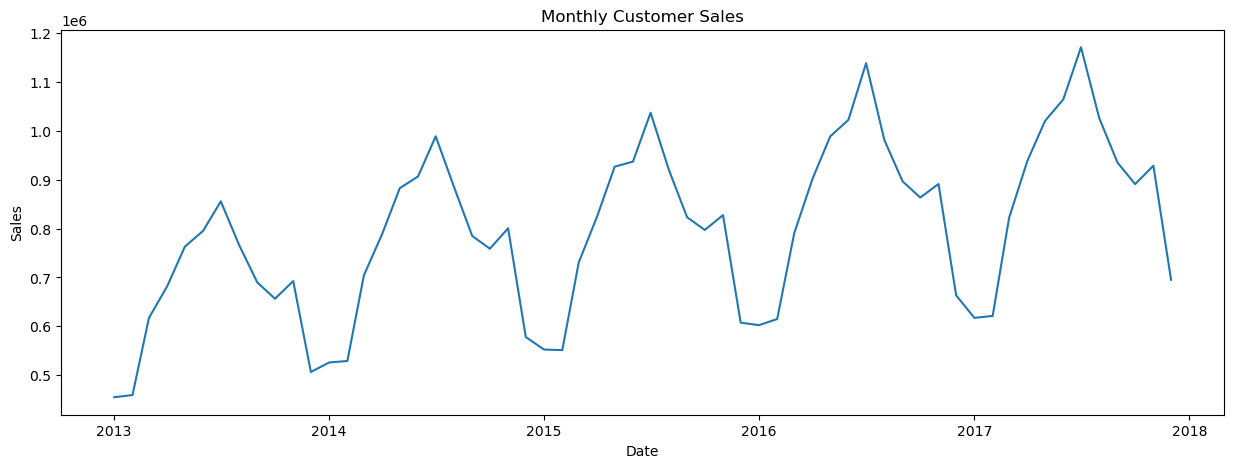

In [12]:
# visualization of monthly sales

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [13]:
# call the difference on the sales columns to make the sales data stationary

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


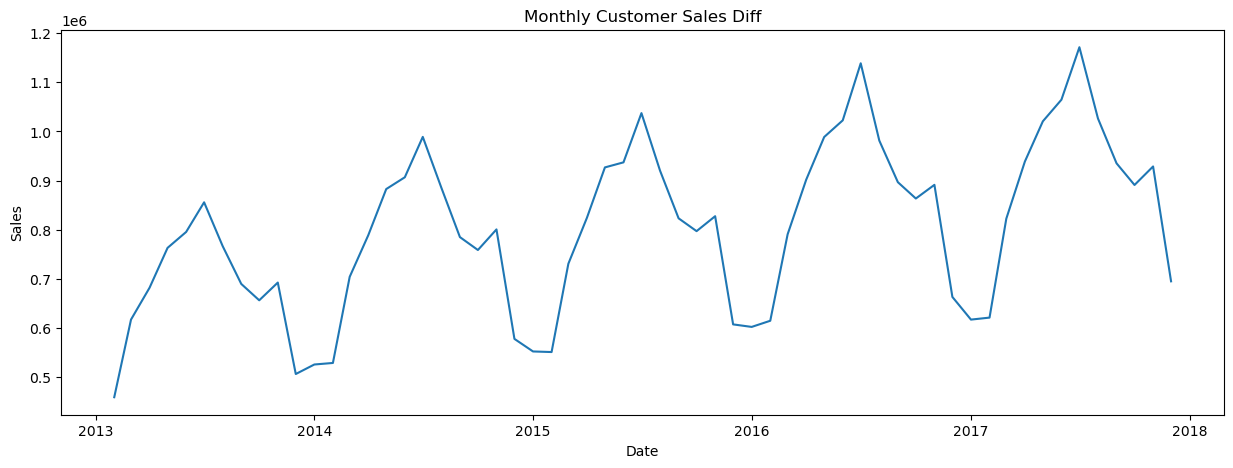

In [14]:
# sales diff visualization

plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Diff")
plt.show()

In [15]:
# dropping off sales and data

supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [16]:
# preparing the supervised data

for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [17]:
# Assuming you have a DataFrame called supervised_data with 'sales_diff' column

# Define the number of lag months
num_lags = 12

# Create lag features
for i in range(1, num_lags + 1):
    col_name = f'month_{i}'
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

# Drop rows with NaN values due to the shifting
supervised_data = supervised_data.dropna().reset_index(drop=True)

# Display the first 10 rows of the resulting DataFrame
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0
1,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0
2,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0
3,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0
4,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0
5,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0
6,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0
7,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0
8,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0
9,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0


In [18]:
# split the data into train and test

train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (23, 13)
Test Data Shape:  (12, 13)


In [19]:
# Min Max scaler to scale feature values

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [20]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("x_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)

x_train Shape:  (23, 12)
y_train Shape:  (23,)
x_test Shape:  (12, 12)
y_test Shape:  (12,)


In [21]:
# Above first coulumn is output and other column is Input

In [22]:
# makeprediction dataframe to merge the predicted sales prices of all trained algs

sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [23]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [24]:
# create linear regression model, and predicted output

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [25]:
lr_pre = lr_pre.reshape(-1,1)

# this is a set matrix - contains the input features of the test data, and also predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [26]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = pd.merge(predict_df, lr_pre_series, left_index=True, right_index=True)


In [27]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.746592e+05
1  2017-02-01       6.349269e+05
2  2017-03-01       8.118111e+05
3  2017-04-01       9.379844e+05
4  2017-05-01       1.028637e+06
5  2017-06-01       1.064925e+06
6  2017-07-01       1.196291e+06
7  2017-08-01       9.949201e+05
8  2017-09-01       9.488273e+05
9  2017-10-01       9.001664e+05
10 2017-11-01       9.127560e+05
11 2017-12-01       7.015780e+05


In [28]:
# Merge the 'Linear Prediction' column into predict_df with a suffix
predict_df = pd.merge(predict_df, lr_pre_series, left_index=True, right_index=True, suffixes=('', '_linear'))

# Calculate and print evaluation metrics
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)


Linear Regression MSE:  22043.446890266427
Linear Regression MAE:  16028.038328796034
Linear Regression R2:  0.9813541328509165


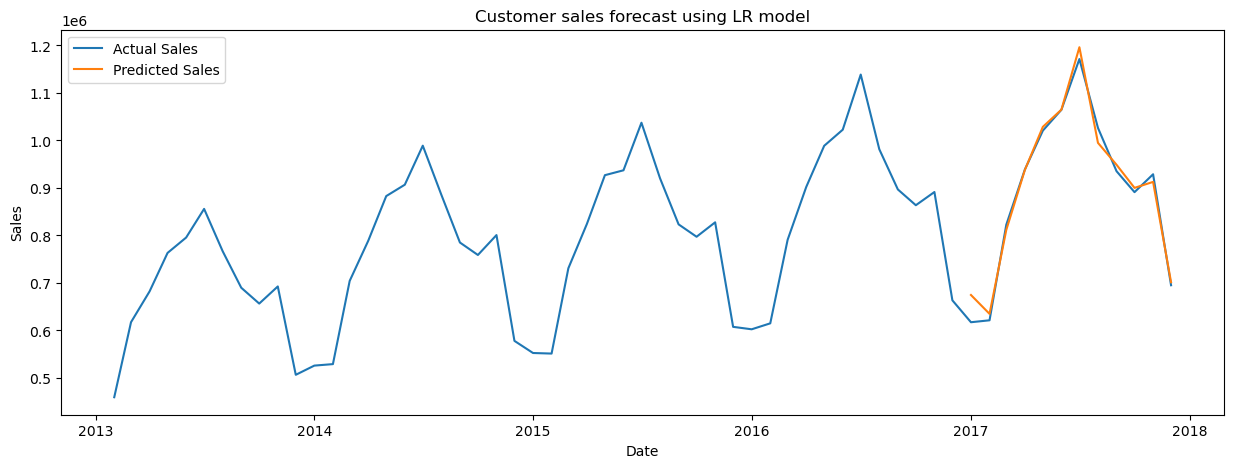

In [32]:
# visualization of the prediction against actual class
plt.figure(figsize=(15, 5))

# actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])

# predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])

plt.title("Customer sales forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])  # Use square brackets and a comma here
plt.show()
